In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
from log_parser import process_file


### parameters

In [3]:
_fname = "../replays/local.log"
_time_step = 100
_symbols = ["PEARLS", "BANANAS"]
_products = ["PEARLS", "BANANAS"]


### pre processing

In [80]:
# load data from file

obj = process_file(_fname)
df = pd.DataFrame(obj)

listings = pd.DataFrame(df["listings"][0])
products = set(listings.T["product"])
df = df.drop("listings", axis=1)
df = df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

Reading from input file ../replays/local.log


In [27]:
# add turns (vs time)

all_times = df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
df["turn"] = df["time"].map(time2turn_map)

df.index = df["turn"]

In [68]:
def process_book(book):
    best_buy = {}
    best_sell = {}
    ret = {}
    cols = ["price", "quantity"]
    for sym in _symbols:
        orders = {
            "buy": pd.DataFrame(columns=cols),
            "sell": pd.DataFrame(columns=cols),
        }
        
        if sym in book:
            if "buy_orders" in book[sym]:
                orders["buy"] = pd.DataFrame(book[sym]["buy_orders"].items(), columns=cols).sort_values(by="price", ascending=False)
            if "sell_orders" in book[sym]:
                orders["sell"] = pd.DataFrame(book[sym]["sell_orders"].items(), columns=cols).sort_values(by="price", ascending=True)
        
        ret[sym] = orders
        
        if len(orders["buy"]) > 0:
            best_buy[sym] = orders["buy"]["price"][0]
        else:
            best_buy[sym] = np.nan
            
        if len(orders["sell"]) > 0:
            best_sell[sym] = orders["sell"]["price"][0]
        else:
            best_sell[sym] = np.nan
            
        
    return ret, best_buy, best_sell


books = pd.DataFrame(df["book"].apply(process_book).to_list(), columns=["book", "best_buy", "best_sell"])
book_tops = books.drop("book", axis=1)

# all book tops
book_tops = pd.concat([book_tops[c].apply(pd.Series).add_suffix(f"_{c}") for c in book_tops.columns], axis=1).astype(int)

for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = df["time"]

# all books
books = books["book"]

In [69]:
num_data = len(book_tops.dropna())
num_data_dropna = len(book_tops)

print(f"Orig count: {num_data}")
print(f"dropna count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 10
dropna count: 10
nan count: 0


In [70]:
def flatten_trades(df, col, is_me):
    # get market trades

    data = []
    for index, row  in df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_action"] = None
    df["my_action"] = np.where(df["buyer"] == "SUBMISSION", "buy", df["my_action"])
    df["my_action"] = np.where(df["seller"] == "SUBMISSION", "sell", df["my_action"])
    df["my_quantity"] = df["quantity"] * df["is_me"].astype(int) * (2 * (df["my_action"] == "buy").astype(int) - 1)
    
    return df

In [71]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")


# filter market trades (only keep those where order_time = fill_time)
market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] == my_trades["order_time"] + _time_step]


trade_df = pd.concat([market_trades, my_trades])
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)
# trade_df = trade_df.drop(["order_time", "buyer", "seller"], axis=1)

my_trades = trade_df[trade_df["is_me"]]
market_trades = trade_df[~trade_df["is_me"]]


In [72]:
# get my_positions
my_positions = pd.DataFrame(list(df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0
        
my_positions[["time", "turn"]] = df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
cash_data = []
cur_cash = 0
cur_time = turn2time_map[0]
for index, row in my_trades.iterrows():
    row_time = row["time"]
    while cur_time < row["time"]:
        cash_data += [cur_cash]
        cur_time = turn2time_map[len(cash_data)]
        
    cur_cash += -1 * row["price"] * row["my_quantity"]

# add for remaining turns
while cur_time < max(turn2time_map.values()):
    cash_data += [cur_cash]
    cur_time = turn2time_map[len(cash_data)]
cash_data += [cur_cash]

# add to my_positions
my_positions["cash"] = cash_data






### Data analysis/vis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

### todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [73]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread,time
0,4995,5005,5000.0,10,9990,10010,10000.0,20,0
1,4995,5005,5000.0,10,9990,10010,10000.0,20,100
2,4995,5005,5000.0,10,9990,10010,10000.0,20,200
3,4995,5005,5000.0,10,9990,10010,10000.0,20,300
4,4995,5005,5000.0,10,9990,10010,10000.0,20,400
5,4995,5005,5000.0,10,9990,10010,10000.0,20,500
6,4995,5005,5000.0,10,9990,10010,10000.0,20,600
7,4995,5005,5000.0,10,9990,10010,10000.0,20,700
8,4995,5005,5000.0,10,9990,10010,10000.0,20,800
9,4995,5005,5000.0,10,9990,10010,10000.0,20,900


In [100]:
# estimate fairs
mid_cols = [col for col in book_tops.columns if "_mid" in col]
fairs = book_tops[["time", *mid_cols]]
fairs.columns = fairs.columns.str.strip('_mid')
fairs

,time,BANANAS,PEARLS
0,0,5000.0,10000.0
1,100,5000.0,10000.0
2,200,5000.0,10000.0
3,300,5000.0,10000.0
4,400,5000.0,10000.0
5,500,5000.0,10000.0
6,600,5000.0,10000.0
7,700,5000.0,10000.0
8,800,5000.0,10000.0
9,900,5000.0,10000.0


In [101]:
# estimate pnl
pnls = my_positions["cash"]

for prod in products:
    pnls += my_positions[prod] * fairs[prod]
    
my_positions["pnl"] = pnls

In [102]:
my_positions

,BANANAS,PEARLS,time,turn,cash,pnl
0,0,0,0,0,0,0.0
1,0,1,100,1,-10010,-10.0
2,0,2,200,2,-20020,-20.0
3,0,3,300,3,-30030,-30.0
4,0,4,400,4,-40040,-40.0
5,0,5,500,5,-50050,-50.0
6,0,6,600,6,-60060,-60.0
7,0,7,700,7,-70070,-70.0
8,0,8,800,8,-80080,-80.0
9,0,9,900,9,-90090,-90.0


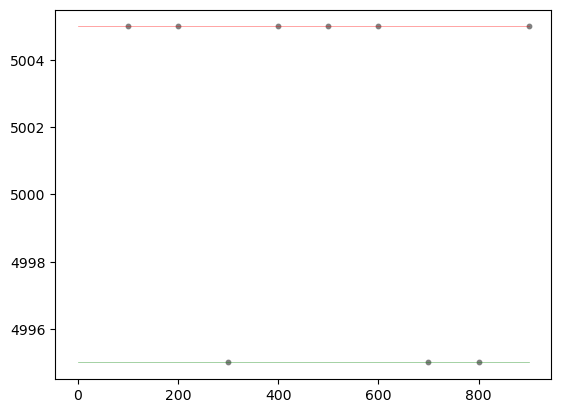

In [103]:
# plot trades

sym = "BANANAS"

plt_df = trade_df[trade_df["symbol"] == sym]

my_buys = plt_df[plt_df["my_quantity"] > 0]
my_sells = plt_df[plt_df["my_quantity"] < 0]
their_trades = plt_df[plt_df["my_quantity"] == 0]

plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)


# plot book
plt.plot(df["time"], book_tops[f"{sym}_best_buy"], c="green", alpha=0.5, linewidth=0.5)
plt.plot(df["time"], book_tops[f"{sym}_best_sell"], c="red", alpha=0.5, linewidth=0.5)

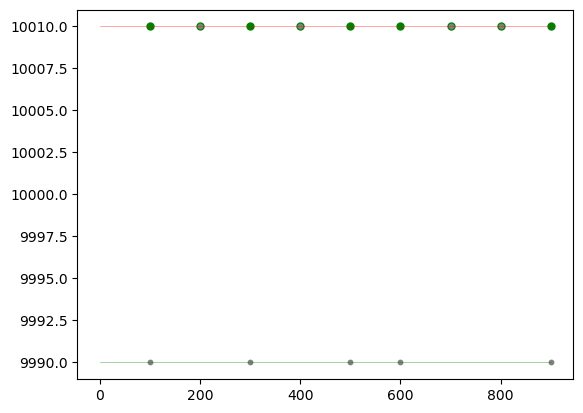

In [104]:
# plot trades

sym = "PEARLS"

plt_df = trade_df[trade_df["symbol"] == sym]

my_buys = plt_df[plt_df["my_quantity"] > 0]
my_sells = plt_df[plt_df["my_quantity"] < 0]
their_trades = plt_df[plt_df["my_quantity"] == 0]

plt.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
plt.scatter(my_sells["time"], my_sells["price"], c="red", s=25)

plt.scatter(their_trades["time"], their_trades["price"], c="gray", s=10)


# plot book
plt.plot(df["time"], book_tops[f"{sym}_best_buy"], c="green", alpha=0.5, linewidth=0.5)
plt.plot(df["time"], book_tops[f"{sym}_best_sell"], c="red", alpha=0.5, linewidth=0.5)

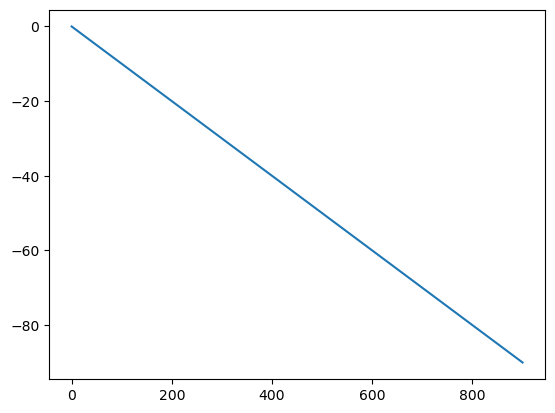

In [105]:
plt.plot(my_positions["time"], my_positions["pnl"])

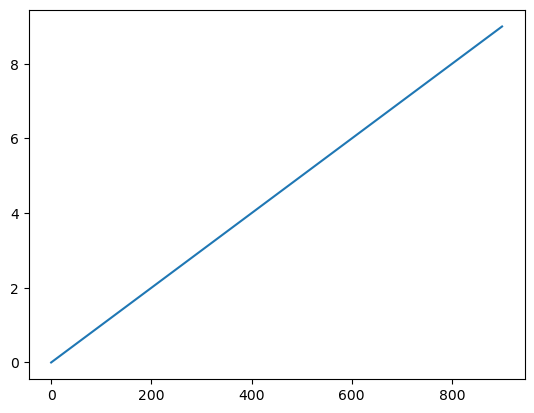

In [52]:
# plot my positions in each product

plt.plot(my_positions["time"], my_positions["PEARLS"])

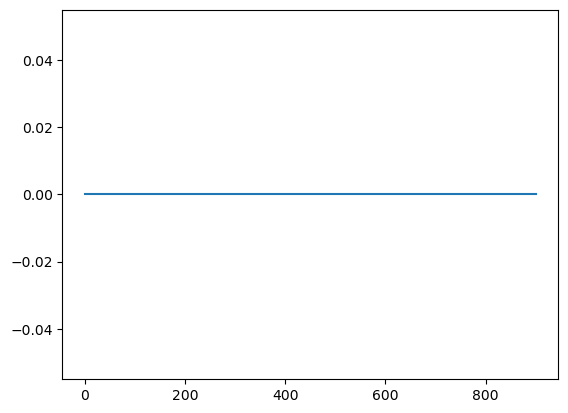

In [53]:
# plot my positions in each product

# plt.bar(my_positions["time"], my_positions["BANANAS"])
plt.plot(my_positions["time"], my_positions["BANANAS"])

In [22]:
book_tops

,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,PEARLS_best_buy,PEARLS_best_sell,PEARLS_mid,PEARLS_spread
0,4995,5005,5000.0,10,9990,10010,10000.0,20
1,4995,5005,5000.0,10,9990,10010,10000.0,20
2,4995,5005,5000.0,10,9990,10010,10000.0,20
3,4995,5005,5000.0,10,9990,10010,10000.0,20
4,4995,5005,5000.0,10,9990,10010,10000.0,20
5,4995,5005,5000.0,10,9990,10010,10000.0,20
6,4995,5005,5000.0,10,9990,10010,10000.0,20
7,4995,5005,5000.0,10,9990,10010,10000.0,20
8,4995,5005,5000.0,10,9990,10010,10000.0,20
9,4995,5005,5000.0,10,9990,10010,10000.0,20


In [26]:
my_positions

,BANANAS,PEARLS,time,turn,cash
0,0,0,0,0,0
1,0,1,100,1,10010
2,0,2,200,2,20020
3,0,3,300,3,30030
4,0,4,400,4,40040
5,0,5,500,5,50050
6,0,6,600,6,60060
7,0,7,700,7,70070
8,0,8,800,8,80080
9,0,9,900,9,90090
